# Weather Data Analysis with a public API

In [1]:
import grequests as asynhttp #Peticiones asincronas
import requests as http
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib
import numpy as np
import plotly.express as px
import plotly.io as pio
#no hay manera de renderizarlo en el notebook
pio.renderers.default = "browser"

### Data Collection and Cleaning

In [2]:
capitales = {
    "Africa": ["El Cairo", "Abuya", "Nairobi", "Addis Abeba", "Pretoria"],
    "America": ["Washington D. C.", "Ottawa", "Ciudad de México", "Brasilia", "Buenos Aires",],
    "Asia": ["Pekín", "Tokio", "Nueva Delhi", "Seúl", "Riad"],
    "Europa": ["Madrid", "París", "Berlín", "Roma", "Londres", "A Coruña"],
    "Oceania": ["Canberra", "Wellington", "Port Moresby", "Suva", "Apia"],
}
key="030c86ad50fe0b9ad9817deeb4fc2825"

Usamos la API geo de OpenWeather para obtener la latitud y longitud de cada ciudad por su nombre, y construimos un dataframe. *La documentación insiste en usar este método, el resto están deprecados.*

*Respecto a **geopy**, este cuaderno ya utiliza una API que maneja tanto coordenadas cómo nombres.*

In [3]:
localizaciones={
    "continente": [],
    "name": [],
    "lat": [],
    "lon": []
}

rs=[]
for continente in capitales:
    for ciudad in capitales[continente]:
        url=f"http://api.openweathermap.org/geo/1.0/direct?q={ciudad}&appid={key}"
        rs.append(asynhttp.get(url))
        localizaciones["continente"].append(continente)
        
futures = asynhttp.map(rs)
for futuro in futures:
    response=futuro.json()    
    localizaciones["name"].append(response[0]["name"])
    localizaciones["lat"].append(response[0]["lat"])
    localizaciones["lon"].append(response[0]["lon"])

In [4]:
df_localizaciones=pd.DataFrame(localizaciones).set_index("name")
df_localizaciones

,continente,lat,lon
name,,,
Cairo,Africa,30.044388,31.235726
Abuja,Africa,9.064331,7.489297
Nairobi,Africa,-1.303264,36.826384
Addis Ababa,Africa,9.010793,38.761252
Pretoria,Africa,-25.745928,28.187910
Washington,America,38.895037,-77.036543
Ottawa,America,45.420878,-75.690111
Mexico City,America,19.432630,-99.133178
Brasília,America,-15.793404,-47.882317


Ahora usamos la API en tiempo real de OpenWeather para obtener el tiempo de cada ciudad. Una vez tenemos todas las respuestas **procesamos el json** para formar un dataframe con la información que nos interesa. 

In [5]:
rs=[]
for entrada in df_localizaciones.values:
    url=f"https://api.openweathermap.org/data/2.5/weather?lat={entrada[1]}&lon={entrada[2]}&appid={key}&units=metric&lang=sp"
    rs.append(asynhttp.get(url))

tiempo=[] 
futures = asynhttp.map(rs)
for futuro in futures:
    tiempo.append(futuro.json())

In [6]:
for ciudad in tiempo:
    for e in ciudad["weather"]:
        del e["id"]
        del e["icon"]

In [7]:
df_tiempo = pd.json_normalize(tiempo, "weather", [["main", "temp"], ["main", "feels_like"],
    ["main", "temp_min"],["main", "temp_max"],["main", "pressure"],["main", "humidity"],
    ["main", "sea_level"],["main", "grnd_level"], "visibility", ["wind", "speed"], ["wind", "deg"], 
    ["wind", "gust"], ["rain", "1h"], ["snow", "1h"], ["clouds", "all"], "dt", "timezone"], sep="-", errors="ignore")

In [8]:
df_tiempo = df_localizaciones.reset_index().join(df_tiempo)

Explorando un poco el dataset, vemos que al convertir el json, **no se han casteado correctamente los tipos numéricos**, al igual que existen valores nulos que deberían ser cero.

In [9]:
df_tiempo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 23 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             26 non-null     object 
 1   continente       26 non-null     object 
 2   lat              26 non-null     float64
 3   lon              26 non-null     float64
 4   main             26 non-null     object 
 5   description      26 non-null     object 
 6   main-temp        26 non-null     object 
 7   main-feels_like  26 non-null     object 
 8   main-temp_min    26 non-null     object 
 9   main-temp_max    26 non-null     object 
 10  main-pressure    26 non-null     object 
 11  main-humidity    26 non-null     object 
 12  main-sea_level   26 non-null     object 
 13  main-grnd_level  26 non-null     object 
 14  visibility       26 non-null     object 
 15  wind-speed       26 non-null     object 
 16  wind-deg         26 non-null     object 
 17  wind-gust        8

In [10]:
# Ejecutar esta casilla por segunda vez genera un error: df_tiempo ha sido alterado definitivamente.
df_tiempo = df_tiempo.astype({"main-temp": "float", "main-feels_like": "float", "main-temp_min": "float", 
                              "main-temp_max": "float", "main-pressure": "int", "main-humidity": "int",
                              "main-sea_level": "int", "main-grnd_level": "int", "visibility": "int", 
                              "wind-speed": "float", "wind-deg": "int", "wind-gust": "float", 
                              "rain-1h": "float", "snow-1h": "float", "clouds-all": "int"})
df_tiempo["dt"] = df_tiempo["dt"] + df_tiempo["timezone"]
df_tiempo["dt"] = pd.to_datetime(df_tiempo["dt"], unit="s", utc=True)
df_tiempo.drop(columns="timezone", inplace=True)

In [11]:
df_tiempo.fillna(0, inplace=True)

In [12]:
df_tiempo.sample(5)

,name,continente,lat,lon,main,description,main-temp,main-feels_like,main-temp_min,main-temp_max,...,main-sea_level,main-grnd_level,visibility,wind-speed,wind-deg,wind-gust,rain-1h,snow-1h,clouds-all,dt
2,Nairobi,Africa,-1.303264,36.826384,Clouds,muy nuboso,15.17,15.09,15.17,15.17,...,1018,839,10000,4.21,52,8.76,0.00,0.0,56,2025-12-06 00:17:25+00:00
16,Paris,Europa,48.858890,2.320041,Clouds,muy nuboso,9.97,7.91,9.01,10.53,...,1021,946,10000,4.12,230,0.00,0.00,0.0,75,2025-12-05 22:17:25+00:00
12,New Delhi,Asia,28.613895,77.209006,Clear,cielo claro,4.26,0.60,3.23,5.90,...,1024,1022,10000,4.63,30,0.00,0.00,0.0,0,2025-12-06 06:17:25+00:00
23,Port Moresby,Oceania,-9.474330,147.159950,Rain,lluvia ligera,17.30,17.28,16.21,17.95,...,1012,1000,10000,7.72,30,0.00,0.11,0.0,20,2025-12-06 10:13:21+00:00
10,Beijing,Asia,39.906217,116.391276,Clear,cielo claro,32.28,33.28,31.64,32.76,...,1005,1004,10000,3.58,84,4.02,0.00,0.0,0,2025-12-05 18:17:25+00:00


In [13]:
df_tiempo.to_csv("tiempo_global.csv")

### Data Analysis
**Which cities are the hottest and coldest right now?**

In [14]:
df_tiempo.loc[df_tiempo.loc[:,"main-temp"].idxmax(), ["name", "main-temp"]]

name         Beijing
main-temp      32.28
Name: 10, dtype: object

In [15]:
df_tiempo.loc[df_tiempo.loc[:,"main-temp"].idxmin(), ["name", "main-temp"]]

name         Ottawa
main-temp     -9.21
Name: 6, dtype: object

**Is there a relationship between temperature and humidity?**

Mostramos un mapa de color de las columnas numéricas más interesantes, podemos ver que la correlación lineal entre humedad es moderada.

In [16]:
df_tiempo.loc[:,["lat", "lon", "main-temp", "main-feels_like", "main-humidity", "main-sea_level", "wind-speed", "wind-gust"]].corr().style.background_gradient(cmap="RdBu", vmin=-1, vmax=1)

,lat,lon,main-temp,main-feels_like,main-humidity,main-sea_level,wind-speed,wind-gust
lat,1.000000,-0.193729,-0.556060,-0.580691,-0.086407,0.080173,-0.068838,0.155806
lon,-0.193729,1.000000,0.064534,0.063665,-0.164112,-0.039594,0.021004,-0.010434
main-temp,-0.556060,0.064534,1.000000,0.993848,-0.193161,-0.378823,0.015397,0.048765
main-feels_like,-0.580691,0.063665,0.993848,1.000000,-0.185243,-0.361372,-0.019411,0.030042
main-humidity,-0.086407,-0.164112,-0.193161,-0.185243,1.000000,0.026485,0.180829,0.111856
main-sea_level,0.080173,-0.039594,-0.378823,-0.361372,0.026485,1.000000,-0.321659,-0.472297
wind-speed,-0.068838,0.021004,0.015397,-0.019411,0.180829,-0.321659,1.000000,0.244422
wind-gust,0.155806,-0.010434,0.048765,0.030042,0.111856,-0.472297,0.244422,1.000000


**Which continent seems to have the windiest cities?**

 Para medir esto tenemos dos posibles valores, la velocidad de las rachas de viento y del viento en general. Creo que es más acertado considerar más las rachas(gust), ya que son el efecto del viento más molesto para las personas.

In [17]:
df_tiempo.groupby("continente")["wind-gust"].max().sort_values(ascending=False)

continente
Europa     14.40
Africa      8.76
Asia        4.02
Oceania     1.02
America     0.00
Name: wind-gust, dtype: float64

In [18]:
df_tiempo.groupby("continente")["wind-speed"].max().sort_values(ascending=False)

continente
Oceania    7.72
Europa     7.72
Asia       4.63
Africa     4.21
America    4.12
Name: wind-speed, dtype: float64

**What’s the most common weather description (e.g., clear, cloudy, rainy)?**

In [19]:
df_tiempo.value_counts("main")

main
Clouds          14
Clear            6
Rain             4
Mist             1
Thunderstorm     1
Name: count, dtype: int64

### Visualization
Realizaremos dos visualizaciones:
1. Una de correlaciones interesantes.
2. Una segunda de temperatura por ciudad y continente.

<Axes: xlabel='Humedad(%)', ylabel='Temp(Cº)'>

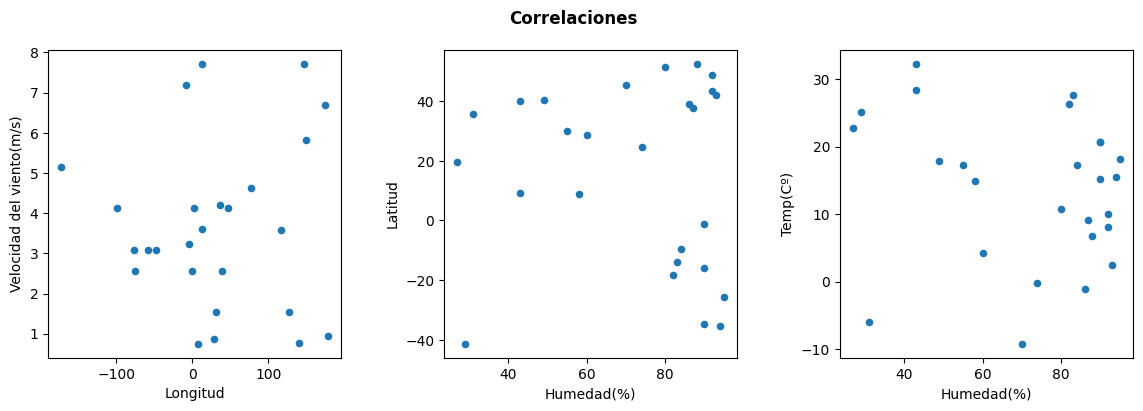

In [20]:
fig,axs = plt.subplots(1,3, figsize=(14,4))
fig.suptitle("Correlaciones", weight="bold")
plt.subplots_adjust(wspace=0.35)
df_tiempo.loc[:,["wind-speed","lon"]].plot.scatter(ax=axs[0], x="lon", y="wind-speed", xlabel="Longitud", ylabel="Velocidad del viento(m/s)")
df_tiempo.loc[:,["main-humidity","lat"]].plot.scatter(ax=axs[1], x="main-humidity", y="lat", xlabel="Humedad(%)", ylabel="Latitud")
df_tiempo.loc[:,["main-temp", "main-humidity"]].plot.scatter(ax=axs[2], x="main-humidity", y="main-temp", xlabel="Humedad(%)", ylabel="Temp(Cº)")

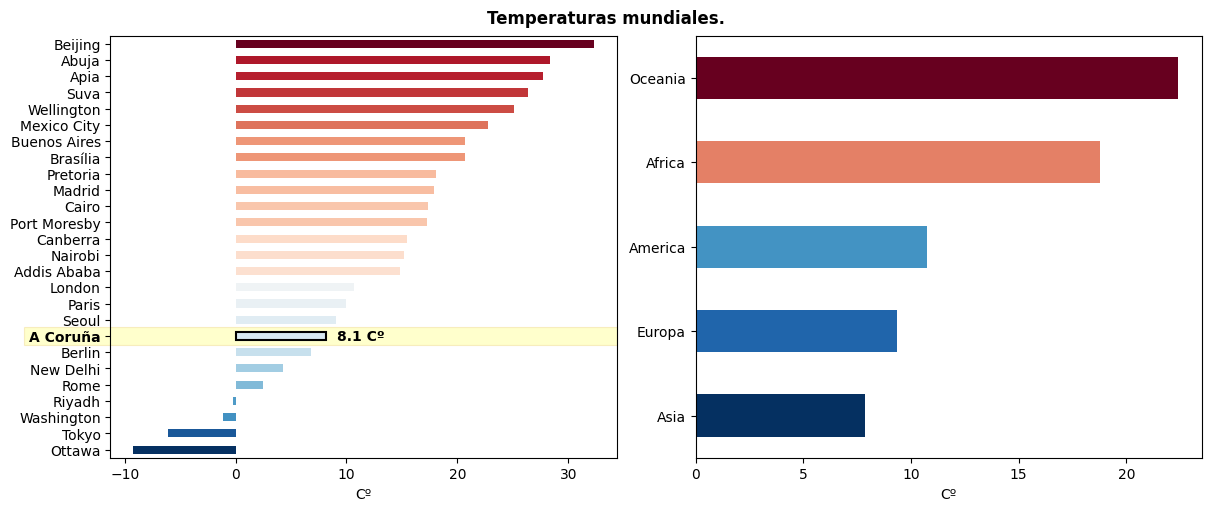

In [21]:
fig,axs = plt.subplots(1,2, figsize=(12, 5), constrained_layout=True)
fig.suptitle("Temperaturas mundiales.", weight="bold")

s_temp=df_tiempo.set_index("name").loc[:,"main-temp"].sort_values() # Importante que esto sea una Serie
norm = matplotlib.colors.Normalize(vmin=s_temp.min(), vmax=s_temp.max())
colors = plt.get_cmap("RdBu_r")(norm(s_temp.values))
bars = s_temp.plot.barh(ax=axs[0], color=colors, xlabel="Cº", ylabel="")


s_temp2=df_tiempo.groupby("continente")["main-temp"].mean().sort_values()
norm = matplotlib.colors.Normalize(vmin=s_temp2.min(), vmax=s_temp2.max())
colors = plt.get_cmap("RdBu_r")(norm(s_temp2.values))
s_temp2.plot.barh(ax=axs[1], color=colors, xlabel="Cº", ylabel="")

#forzamos el renderizado para que los calculos sean sobre objetos y una figura que existen.
fig.canvas.draw() 

city="A Coruña"
if city in s_temp.index:
    i = list(s_temp.index).index(city)
    bar = axs[0].patches[i]
    label = axs[0].get_yticklabels()[i]
    bar.set_linewidth(1.5)
    bar.set_edgecolor("black")
    label.set_fontweight("bold")

    axs[0].text(
        bar.get_width()+ 1,
        bar.get_y(),
        f"{bar.get_width():.1f} Cº",
        fontsize=10,
        fontweight="semibold",
        color="black",
    )
    
    lbl_disp = label.get_window_extent()
    bar_disp = bar.get_window_extent()
    ax_disp = axs[0].get_window_extent()
    padding=5
    highlight = matplotlib.transforms.Bbox.from_extents(lbl_disp.x0-padding, bar_disp.y0-padding, 
                                                        ax_disp.x1, bar_disp.y1+padding)
    
    highlight = highlight.transformed(fig.transFigure.inverted())
    x0, y0, w, h = highlight.x0, highlight.y0, highlight.width, highlight.height
    rect = matplotlib.patches.Rectangle(
        (x0, y0), w, h,
        transform=fig.transFigure,
        facecolor="yellow",
        alpha=0.2,
        edgecolor="goldenrod",
        linewidth=0.8,
        clip_on=False,
        zorder=0.1,
    )
    axs[0].add_patch(rect)

plt.show()
#TODO: estaría bien añadir un eje con la hora del día

### Bonus
**Compare current vs forecasted data and Compute temperature differences by time of day.**

Para simplificar y aligerar carga de trabajo, fusionaremos estos dos putos en uno solo. Empezaremos consultando unicamente el tiempo en coruña y preparando el datase a partir del json, al igual que en los apartados anteriores. Vamos a usar la api de OpenWeather que devuelve las prediciones cada tres horas para los próximos cinco días.

In [22]:
forecast_url_5 = "https://api.openweathermap.org/data/2.5/forecast"
forecast_url_16 = "https://api.openweathermap.org/data/2.5/forecast/daily"
coruña=df_tiempo.query("name == 'A Coruña'")
params = {
        "lat": coruña.lat.iloc[0],
        "lon": coruña.lon.iloc[0],
        "appid": key,
        "units": "metric",
        "lang": "es",
    }
response = http.get(forecast_url_5, params=params)

In [23]:
list_json=response.json()["list"]
for e in list_json:
    for i in e["weather"]:
        del i["id"]
        del i["icon"]

Igual que en el punto anterior, esta forma de normalizar json **no interpreta correactamente los tipos de datos**. Tendremos que asignar a cada columna su tipo manualmente y despues rellenar los nulos numéricos con ceros, que corresponden con campos que son opcionales cómo la lluvia.

In [24]:
df_forecast = pd.json_normalize(list_json, "weather",[["main", "temp"],["main", "feels_like"],["main", "temp_min"],
                                                     ["main", "temp_max"],["main", "pressure"],["main", "sea_level"],
                                                     ["main", "grnd_level"],["main", "humidity"], ["clouds", "all"],
                                                     ["wind", "speed"],["wind", "deg"],["wind", "gust"], "visibility",
                                                     "pop",["rain", "3h"],["snow", "3h"],["sys", "pod"], "dt",
                                                     "dt_txt"], sep="-", errors="ignore")
df_forecast.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   main             40 non-null     object
 1   description      40 non-null     object
 2   main-temp        40 non-null     object
 3   main-feels_like  40 non-null     object
 4   main-temp_min    40 non-null     object
 5   main-temp_max    40 non-null     object
 6   main-pressure    40 non-null     object
 7   main-sea_level   40 non-null     object
 8   main-grnd_level  40 non-null     object
 9   main-humidity    40 non-null     object
 10  clouds-all       40 non-null     object
 11  wind-speed       40 non-null     object
 12  wind-deg         40 non-null     object
 13  wind-gust        40 non-null     object
 14  visibility       40 non-null     object
 15  pop              40 non-null     object
 16  rain-3h          14 non-null     object
 17  snow-3h          0 non-null      obje

In [25]:
# Ejecutar esta casilla por segunda vez genera un error: df_tiempo ha sido alterado definitivamente.
df_forecast = df_forecast.astype({"main": "str", "description": "str","main-temp": "float", "main-feels_like": "float", "main-temp_min": "float", 
                                  "main-temp_max": "float", "main-pressure": "int", "main-humidity": "int", "main-sea_level": "int", "main-grnd_level": "int",
                                  "visibility": "int", "sys-pod": "str", "wind-speed": "float", "wind-deg": "int", "wind-gust": "float",
                                  "rain-3h": "float", "snow-3h": "float", "clouds-all": "int"})

df_forecast["dt"] = pd.to_datetime(df_forecast["dt"], unit="s", utc=True)

In [26]:
df_forecast.fillna(0, inplace=True)

In [27]:
df_forecast.sample(5)

,main,description,main-temp,main-feels_like,main-temp_min,main-temp_max,main-pressure,main-sea_level,main-grnd_level,main-humidity,...,wind-speed,wind-deg,wind-gust,visibility,pop,rain-3h,snow-3h,sys-pod,dt,dt_txt
21,Clouds,nubes,16.67,16.19,16.67,16.67,1011,1011,1001,69,...,11.37,190,20.74,10000,0,0.00,0.0,d,2025-12-08 15:00:00+00:00,2025-12-08 15:00:00
31,Rain,lluvia ligera,11.87,11.49,11.87,11.87,1019,1019,1009,91,...,3.19,178,3.77,10000,0.5,0.26,0.0,n,2025-12-09 21:00:00+00:00,2025-12-09 21:00:00
14,Clouds,nubes,16.02,15.64,16.02,16.02,1017,1017,1007,75,...,8.01,195,15.45,10000,0,0.00,0.0,n,2025-12-07 18:00:00+00:00,2025-12-07 18:00:00
11,Clouds,nubes,15.62,15.14,15.62,15.62,1017,1017,1007,73,...,9.14,195,17.00,10000,0,0.00,0.0,d,2025-12-07 09:00:00+00:00,2025-12-07 09:00:00
28,Rain,lluvia moderada,14.82,14.68,14.82,14.82,1010,1010,1000,89,...,8.34,218,18.36,3981,1,4.82,0.0,d,2025-12-09 12:00:00+00:00,2025-12-09 12:00:00


Vamos a presentar un gŕafico de las predicciones de temperatura y posibilidad de precipitaciones. Por cómo está planteada la gráfica, podríamos añadir el parametro que quisieramos a la representación.

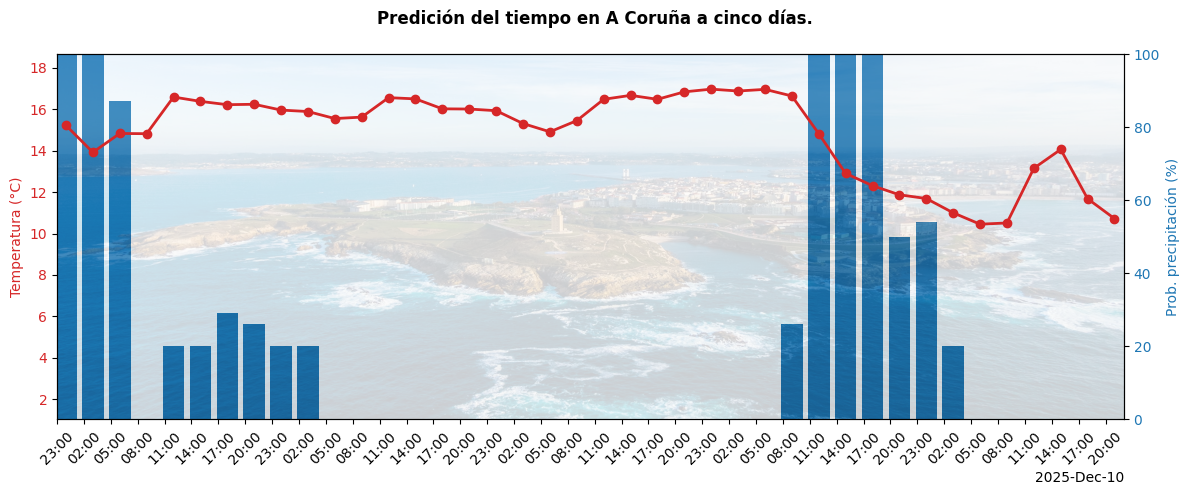

In [28]:
AZUL_CLARITO="#1f77b4"
ROJO_CLARO="#d62728"

df_forecast.sort_values("dt", inplace=True)
x = df_forecast["dt"]
y_temp = df_forecast["main-temp"]
pop = df_forecast["pop"].mul(100)

fig, ax_temp = plt.subplots(figsize=(12,5))
line = ax_temp.plot(x, y_temp, color=ROJO_CLARO, linewidth=2.0, marker="o", markersize=6)
ax_temp.set_ylabel("Temperatura (°C)", color=ROJO_CLARO)
ax_temp.tick_params(axis="y", labelcolor=ROJO_CLARO)

#Entre 24 porque date2num es el numero de dias desde el epoch
#Para que la imagen se vea bien, el eje tiene que saber que forma tiene
xlimits = (mdates.date2num(x.min())-(1/24), mdates.date2num(x.max())+(1/23))
ylimits = (y_temp.min()*0.1, y_temp.max()*1.1)
ax_temp.set_xlim(*xlimits)
ax_temp.set_ylim(*ylimits)
ax_temp.imshow(matplotlib.image.imread('coruña.jpg'), alpha=0.2, zorder=0, aspect="auto", extent=[*xlimits, *ylimits])

#Sabemos que los intervalos son de 3 horas, tanto para las barras
#cómo para el Locator. Me di cuenta tarde. 
ax_pop = ax_temp.twinx()
bin_hours = x.diff().dropna().dt.total_seconds().div(3600).mean()
bar_width_days = (bin_hours / 24.0) * 0.8
ax_pop.bar(x, pop, width=bar_width_days, alpha=1, label="Prob. precipitación (%)")

ax_pop.set_ylabel("Prob. precipitación (%)", color=AZUL_CLARITO)
ax_pop.tick_params(axis="y", labelcolor=AZUL_CLARITO)
ax_pop.set_ylim(0, 100)

ax_temp.xaxis.set_major_locator(mdates.HourLocator(interval=bin_hours.astype(np.int16)))
ax_temp.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax_temp.xaxis.get_major_locator()))
for label in ax_temp.get_xticklabels(which='major'):
    label.set(rotation=45)

ax_temp.set_zorder(2)
ax_pop.set_zorder(1)
ax_temp.patch.set_visible(False)
fig.suptitle("Predición del tiempo en A Coruña a cinco días.", weight="bold")
fig.tight_layout()

plt.show()

**Map the results on a world map using Plotly or Folium.**

In [29]:
fig = px.scatter_geo(
    df_tiempo,
    lat="lat",
    lon="lon",
    hover_name="name",
    text=[x for x in df_tiempo["main-temp"]],
    projection="natural earth"
)

fig.update_geos(
    showcountries=True,
    showcoastlines=True,
    showland=True,
    landcolor="#F0F0F0",
    coastlinecolor="#777",
    lataxis_showgrid=True,
    lonaxis_showgrid=True,
)

fig.update_traces(
    marker=dict(size=6, color="#d62728", opacity=0.8)
)

fig.update_layout(
    title="Ciudades en mapa mundial",
    margin=dict(l=0, r=0, t=40, b=0),
)

fig.show()

![El resultado del mapa]("mapaplotpy.png")

### Summary
Los datos que vemos son los esperados en esta época del año (11 de diciembre), destacar que la mayor correlación de los valores es con la latitud y longitud; siendo poca por ejemplo entre humedad y temperatura. Aunque la valoración de **los datos a nivel global, hace que se difumine la especificidad y la localidad del clima**, la diferencia entre ambos hemisferios es palpable. Un detalle a tener en cuenta sobre la API es que *durante la madrugada deja de sincronizarse y otras veces pierde precision*.

En el aspecto técnico, me he chocado con dos problemas que me han consumido gran cantidad del tiempo. La primera es la dificultad para procesas la repsuesta json y encuadrarla tabularmente en un dataframe, la segunda fue a la hora de generar el mapa de color para el gráfico de barras, el comportamiento de este cuando se usa una Serie o un DataFrame es muy diferente. En el mismo sentido, el gráfico de las predicciones se ha complicado mucho al trabajar con fechas. El resultado que saco es positivo, he aprendido sobre cómo pandas trabaja con fechas, a volcar datos mediante json y a representar los dos datos de una forma más clara.

